## 1 Functions and module

### 1.1 Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import math
import seaborn as sns
import re
import scipy.stats as SS
%matplotlib inline 
import copy

In [2]:
pd.set_option('display.max_columns', None)

### 1.2 Functions

In [3]:
def Generate_DF_for_Correlation(input_df, unit_name, trait_of_interest):
    temp_name_list = input_df['Sample_ID'].unique()
    temp_column_list = [unit_name,trait_of_interest]

    temp_1 = input_df[input_df['Sample_ID'] == temp_name_list[0]][temp_column_list]
    temp_1.rename(columns={trait_of_interest:temp_name_list[0]}, inplace=True)
    for x in temp_name_list[1:]:
        temp_2 = input_df[input_df['Sample_ID'] == x][temp_column_list]
        temp_2.rename(columns={trait_of_interest:x}, inplace=True)
        temp_1 = temp_1.merge(temp_2,on=unit_name,how = 'outer')
    return(temp_1)

In [4]:
def generate_shared_number_matrix(df):
    non_nulls = df.notna()
    shared_non_null_matrix = pd.DataFrame(np.zeros((len(df.columns), len(df.columns))), index=df.columns, columns=df.columns)
    fraction_matrix = pd.DataFrame(np.zeros((len(df.columns), len(df.columns))), index=df.columns, columns=df.columns)
    # Fill the symmetric matrix with shared non-null counts
    for col1 in non_nulls.columns:
        for col2 in non_nulls.columns:
            # Count the shared non-null rows for the pair
            shared_count = (non_nulls[col1] & non_nulls[col2]).sum()
            # Fill both symmetric positions in the matrix
            shared_non_null_matrix.loc[col1, col2] = shared_count
            shared_non_null_matrix.loc[col2, col1] = shared_count
    # Convert counts to shared fractions
    for col in df.columns:
        for row in df.columns:
                # Calculate the shared fraction as count divided by the minimum non-null count of the two columns
                shared_fraction = shared_non_null_matrix.loc[col, row] /shared_non_null_matrix.loc[col, col]
                # Update the symmetric matrix with the shared fraction
                fraction_matrix.loc[col, row] = shared_fraction

    # Display the symmetric matrix
    return(shared_non_null_matrix,fraction_matrix)

In [5]:
def Spikein_summary_Cas12a(input_df, input_cell_number):
# this function extract spike reads for each kind in each sample
    temp_df = input_df.groupby(['Sample_ID','Targeted_gene_name'],as_index = False).agg(
        Unique_spikein_barcode_number = pd.NamedAgg('Clonal_barcode',aggfunc = lambda x: len(x)), # number of different spike-in barcode
        Count = pd.NamedAgg('Count',aggfunc = np.sum)
    )
    temp_df['Cell_per_read'] = input_cell_number/temp_df['Count']
    temp_df['Amplification'] = temp_df.Count/temp_df.Unique_spikein_barcode_number
    return(temp_df)

In [6]:
# calculate the combined spikein metrics for each sample
def Cal_Spike_in_Ratio(x):
    d = {}
    temp_name_list = ['tuba-seq-v2_Spike-in-1','tuba-seq-v2_Spike-in-2','tuba-seq-v2_Spike-in-3'] # this is spike in name_list 
    temp_vect = x[['Targeted_gene_name','Count']]
    s1_value = x[x['Targeted_gene_name'] == temp_name_list[0]]['Count'].values[0]
    s2_value = x[x['Targeted_gene_name'] == temp_name_list[1]]['Count'].values[0]
    s3_value = x[x['Targeted_gene_name'] == temp_name_list[2]]['Count'].values[0]
    d['tuba-seq-v2_Spike-in-1'] = s1_value
    d['tuba-seq-v2_Spike-in-2'] = s2_value
    d['tuba-seq-v2_Spike-in-3'] = s3_value
    d['Mean_count'] = (s1_value+s2_value+s3_value)/3 # mean count for spike in 
    s1_s2_ratio =  s1_value/s2_value# spikein 1/ spikein 2 ratio
    s1_s3_ratio =  s1_value/s3_value# spikein 1/ spikein 2 ratio
    d['s1_s2_ratio'] = s1_s2_ratio
    d['s1_s3_ratio'] = s1_s3_ratio
    d['max_least_ratio'] = sorted([s1_value,s2_value,s3_value])[-1]/sorted([s1_value,s2_value,s3_value])[0]
    return pd.Series(d, index=list(d.keys())) 

In [7]:
def Generate_Simple_Sample_Summary_Cas12a(input_df,input_spikein_df,trait_name_list):
    temp_df0 = input_df.groupby(trait_name_list,as_index=False).agg(
        TTR = pd.NamedAgg('Count',aggfunc = sum)) # total reads
    temp_df1 = input_spikein_df.groupby('Sample_ID',as_index=False)['Count'].sum() # sum of index read for each sample
    spikein_name_list = ['tuba-seq-v2_Spike-in-1','tuba-seq-v2_Spike-in-2','tuba-seq-v2_Spike-in-3'] # spike in name should be ordered here
    temp_spike_df = input_spikein_df.set_index('Sample_ID')
    temp_df0['Spike1_reads_fraction'] = temp_spike_df[temp_spike_df['Targeted_gene_name']==spikein_name_list[0]].loc[temp_df0.Sample_ID]['Count'].to_list()/(temp_df0.TTR+temp_df1.Count)
    temp_df0['Spike2_reads_fraction'] = temp_spike_df[temp_spike_df['Targeted_gene_name']==spikein_name_list[1]].loc[temp_df0.Sample_ID]['Count'].to_list()/(temp_df0.TTR+temp_df1.Count)
    temp_df0['Spike3_reads_fraction'] = temp_spike_df[temp_spike_df['Targeted_gene_name']==spikein_name_list[2]].loc[temp_df0.Sample_ID]['Count'].to_list()/(temp_df0.TTR+temp_df1.Count)
    return(temp_df0)

In [8]:
def Generate_Conversion_factor(input_spike_df, input_candidate_list, input_spike_in_list,temp_spikein_cell_number):
    # this function generate a df storing cell number per reads
    # input_spike_df is the df contain the spikein information (spikein_ratio_df)
    # temp_spikein_cell_number is the cell number for each spike in added into sample (usually it is 100K)
    # for most sample, I will use temp_spikein_cell_number/ mean(spike in reads)
    # input_candidate_list is the list of sample id whose spikein needed special treatment
    # temp_spikein_cell_number specify which spike in will be use for each sample ID who need special treatment
    input_dic = dict(zip(input_candidate_list, input_spike_in_list))
    temp_dic = {}
    for index,row in input_spike_df.iterrows():
        temp_id = row['Sample_ID']
        if temp_id in input_dic.keys():
            # print(row[input_dic.get(id)])
            temp_value = row[input_dic.get(temp_id)].mean()
        else:
            temp_value = row['Mean_count']
        temp_dic[temp_id] = temp_spikein_cell_number/temp_value
    temp_df = pd.DataFrame({'Sample_ID':temp_dic.keys(),
                       'Cell_number_per_read':temp_dic.values()})
    temp_df['Correction_for_spikein'] = temp_df['Sample_ID'].apply(lambda x: 'Yes' if (x in input_candidate_list) else 'No')
    return(temp_df.sort_values(by=['Correction_for_spikein','Cell_number_per_read']))
        

In [9]:
def Final_df_Generation(input_df,input_conversion_factor_df):
    # input_df is the dataframe input
    # input_conversion_factor_df is the dictionary that store the the cell number per reads
    temp_df = input_df.merge(input_conversion_factor_df, on ='Sample_ID')
    temp_df['Cell_number'] = temp_df['Count']*temp_df['Cell_number_per_read']
    return(temp_df)

In [10]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']),size = 8)

In [11]:
# calculate the summary metrics for each sample
def Cal_Sample_Summary(x):
    d = {}
    temp_vect = x['Cell_number']
    if type (temp_vect) == 'int':
        temp_vect = [temp_vect]
    d['TTB'] = sum(temp_vect) # total mutational burdern 
    d['TTN'] = len(temp_vect) # this is total tumor number
    return pd.Series(d, index=list(d.keys())) 

----

## 2 Input and output address

In [ ]:
parent_address = "data/"
combined_df_address = parent_address + "gRNA_clonalbarcode_combined_SCLC.csv"
# gRNA information address
gRNA_info_address = parent_address + "sgRNA_Cas12a_combine.csv"
# experimental information address
exp_info_address = parent_address + "Mice_info_standardized_SCLC.csv"
spike_in_address = parent_address + "SpikeInRead_SCLC.csv"

In [13]:
sample_summary_address = parent_address + "Ca12a_SCLC_sample_summary_df.csv"
final_data_output_address = parent_address + 'Ca12a_SCLC_final_df.parquet'

---

## 3 Raw data processing

### 3.1 Read NGS data for tumor

In [14]:
test_df = pd.read_csv(combined_df_address).rename(columns={'Frequency':'Count'})

### 3.2 Read gRNA info

In [30]:
ref_df = pd.read_csv(gRNA_info_address)
ref_df = ref_df.rename(columns={'Guide1_sequence':'gRNA1','Guide2_sequence':'gRNA2','Guide3_sequence':'gRNA3',}).drop(['Guide2','gRNA2','DR1','DR2','DR6'],axis=1)
ref_df['Array_name'] = ref_df['Array name'].apply(lambda x: re.sub(r'\d+', '', x.split('_')[0]))
ref_df = ref_df.drop('Array name',axis=1).drop_duplicates()

### 3.3 Read mice info

In [31]:
mice_info = pd.read_csv(exp_info_address)

In [32]:
mice_info.rename(columns = {'Sample ID':'Sample_ID','Mouse_Genotype':'Mouse_genotype',
                            'Virus_Titer':'Virus_titer','Time_After_Tumor_Initiation(wks)':'Time_after_tumor_initiation',
                                 'Total_Lung_Weight(g)':'Total_lung_weight'}, inplace = True)

### 3.4 Read spikein info

In [33]:
temp_dic = dict({'GAGTTCTGCCTCAAGCAAGT':'tuba-seq-v2_Spike-in-1','GTTGAATCGTCCGTACATGT':'tuba-seq-v2_Spike-in-2','TATACTTGCACCATGCCATA':'tuba-seq-v2_Spike-in-3'})

In [34]:
spikein_raw_df = pd.read_csv(spike_in_address)

In [35]:
spikein_raw_df['Targeted_gene_name'] = spikein_raw_df['gRNA'].apply(lambda x: temp_dic.get(x))

### 3.5 Merge all df

In [36]:
test_df = test_df.merge(ref_df,on=['gRNA1','gRNA3'])
test_df['Class'] = 'Original'
test_df.loc[~test_df['Array_name'].str.contains('crSCLC'),'Class'] = 'Contaminated'
raw_summary_df = test_df.merge(mice_info, on ='Sample_ID')
raw_summary_df['gRNA_clonalbarcode'] = raw_summary_df['gRNA_combination']+'_' + raw_summary_df['Clonal_barcode']

----

## 4 Spikein QC

### 4.1 Count spikein read numbers and ratio

In [37]:
spikein_df = Spikein_summary_Cas12a(spikein_raw_df,50000).sort_values(by='Cell_per_read',ascending=False)

In [38]:
spikein_df.head()

,Sample_ID,Targeted_gene_name,Unique_spikein_barcode_number,Count,Cell_per_read,Amplification
16,LA77_03B,tuba-seq-v2_Spike-in-2,89,143,349.650350,1.606742
4,LA77_01B,tuba-seq-v2_Spike-in-2,109,178,280.898876,1.633028
17,LA77_03B,tuba-seq-v2_Spike-in-3,111,186,268.817204,1.675676
5,LA77_01B,tuba-seq-v2_Spike-in-3,124,196,255.102041,1.580645
3,LA77_01B,tuba-seq-v2_Spike-in-1,143,252,198.412698,1.762238


In [39]:
spikein_ratio_df = spikein_df.groupby(['Sample_ID'],as_index = False).apply(Cal_Spike_in_Ratio) # the ratio of spike in

In [40]:
spikein_ratio_df.head()

,Sample_ID,tuba-seq-v2_Spike-in-1,tuba-seq-v2_Spike-in-2,tuba-seq-v2_Spike-in-3,Mean_count,s1_s2_ratio,s1_s3_ratio,max_least_ratio
0,LA77_01,357.0,264.0,280.0,300.333333,1.352273,1.275000,1.352273
1,LA77_01B,252.0,178.0,196.0,208.666667,1.415730,1.285714,1.415730
2,LA77_02,1112.0,712.0,805.0,876.333333,1.561798,1.381366,1.561798
3,LA77_02B,1319.0,925.0,1023.0,1089.000000,1.425946,1.289345,1.425946
4,LA77_03,813.0,257.0,382.0,484.000000,3.163424,2.128272,3.163424


### 4.2 Find samples with unusual spike in ratio

Text(0, 0.5, 's1/s3')

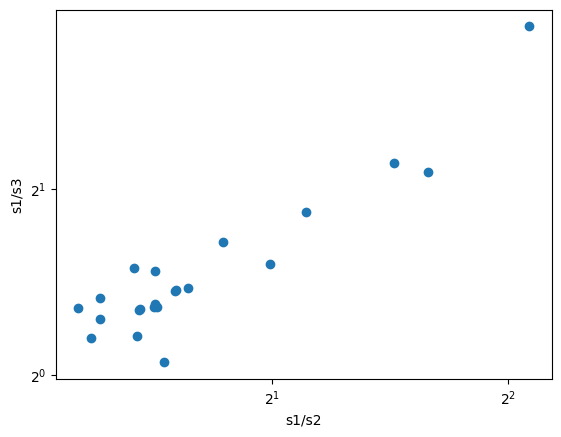

In [41]:
plt.scatter(spikein_ratio_df.s1_s2_ratio,spikein_ratio_df.s1_s3_ratio)
# label_point(spikein_ratio_df.s1_s2_ratio,spikein_ratio_df.s1_s3_ratio, spikein_ratio_df['Sample_ID'], plt.gca())
plt.xscale('log',base = 2)
plt.yscale('log',base = 2)
plt.xlabel('s1/s2')
plt.ylabel('s1/s3')

Text(0, 0.5, 's1/s3')

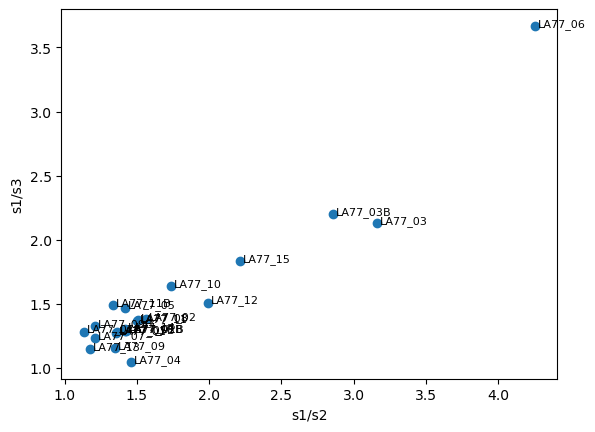

In [42]:
plt.scatter(spikein_ratio_df.s1_s2_ratio,spikein_ratio_df.s1_s3_ratio)
label_point(spikein_ratio_df.s1_s2_ratio,spikein_ratio_df.s1_s3_ratio, spikein_ratio_df['Sample_ID'], plt.gca())
# plt.xscale('log',base = 2)
# plt.yscale('log',base = 2)
plt.xlabel('s1/s2')
plt.ylabel('s1/s3')

<font size="5" color =  black> Sample <mark>LA77_06, LA77_03, LA77_03B</mark> have distorted ratio between spikein</font>

### 4.3 Find bad spike in for those samples

In [45]:
input_ratio_cutoff = 2.5 # this is the cutoff 
temp_bad_list = spikein_ratio_df.loc[spikein_ratio_df['max_least_ratio']>input_ratio_cutoff,'Sample_ID'].to_list() # list of sample with bad spikein

/var/folders/xv/26kbh4lj2rjdcrxz37m9wxyw0000gn/T/ipykernel_56929/1708176043.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_xticklabels(['spike_in_1','spike_in_2','spike_in_3'])
/var/folders/xv/26kbh4lj2rjdcrxz37m9wxyw0000gn/T/ipykernel_56929/1708176043.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_xticklabels(['spike_in_1','spike_in_2','spike_in_3'])
/var/folders/xv/26kbh4lj2rjdcrxz37m9wxyw0000gn/T/ipykernel_56929/1708176043.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  x.set_xticklabels(['spike_in_1','spike_in_2','spike_in_3'])


Text(0.5, 0.95, 'Samples with unexpected spike-in ratio (>2.5)')

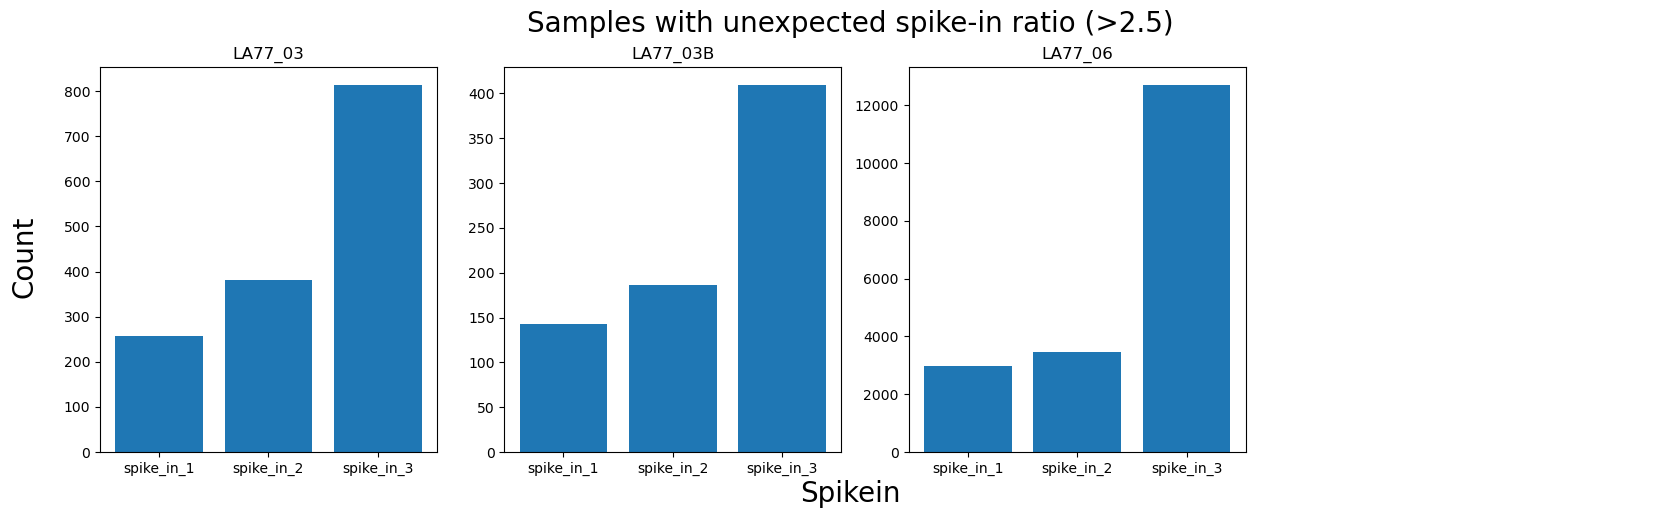

In [46]:
# check the max/min ratio in each sample and print those sample with ratio above certain cutoff
fig1,ax = plt.subplots(math.ceil(len(temp_bad_list)/4), 4, figsize=(20,5*math.ceil(len(temp_bad_list)/4)))
axes = ax.flatten()
for x,y in zip(axes[:len(temp_bad_list)],temp_bad_list):
    temp_df = spikein_df[spikein_df['Sample_ID'] == y]
    x.bar(temp_df['Targeted_gene_name'],temp_df['Count'])
    x.set_title(y)
    x.set_xticklabels(['spike_in_1','spike_in_2','spike_in_3'])
for x in axes[len(temp_bad_list):]:
    x.set_axis_off()
fig1.text(0.08, 0.5, 'Count', va='center', rotation='vertical',fontsize=20)
fig1.text(0.5, 0.01, 'Spikein', ha='center',fontsize=20)
fig1.text(0.5, 0.95, 'Samples with unexpected spike-in ratio (>{})'.format(input_ratio_cutoff), ha='center',fontsize=20)
# fig1.savefig(figure_output_address+'QC_332.pdf')aa

* <font size="5" color =  black> If we assume only one of the spikein has a problem, the one with extraordinary <mark> high </mark> count (spike_in_1) seems to be the problematic one</font>

----

## 5 Correct Cell per reads

In [47]:
temp = [['tuba-seq-v2_Spike-in-2','tuba-seq-v2_Spike-in-3'],['tuba-seq-v2_Spike-in-2','tuba-seq-v2_Spike-in-3'],['tuba-seq-v2_Spike-in-2','tuba-seq-v2_Spike-in-3']]
conversion_factor_df= Generate_Conversion_factor(spikein_ratio_df,['LA77_03','LA77_03B','LA77_06'],temp,50000)

In [48]:
Final_df = Final_df_Generation(raw_summary_df,conversion_factor_df)

In [44]:
Final_df.to_parquet(final_data_output_address,index =False)

---

## 6 Overall sample QC 

In [49]:
def Generate_Sample_Summary_Ca12a(input_df, input_spikein_check_df,input_cell_number_cutoff,input_read_cutoff):
    # input_cell_number_cutoff is the cell number cutoff
    # input_rad_cutoff is the read cutoff
    # Total reads does not restricted to gRNA or cell number cutoff
    temp_df0 = input_df.groupby(['Sample_ID','Mouse_Ear_Tag','Mouse_genotype', 'Sex','Tissue',
         'Time_after_tumor_initiation', 'Total_lung_weight', 'Virus_titer','Correction_for_spikein','Cell_number_per_read'],as_index=False).agg(
        TTR = pd.NamedAgg('Count',aggfunc = sum))
    temp_df0 = temp_df0.merge(input_spikein_check_df[['Sample_ID','Mean_count','max_least_ratio']],on = 'Sample_ID') # merge spike in info
    temp_df0['Spikein_read_ratio'] = (temp_df0['Mean_count']*3)/(temp_df0['TTR']+(temp_df0['Mean_count']*3))
    # filter input data
    temp_input = input_df[(input_df['Cell_number']>=input_cell_number_cutoff)&(input_df['Count']>input_read_cutoff)]
    # I only consider non-spikein gRNA
    temp_df1 = temp_input.groupby(
        ['Sample_ID'],as_index = False).apply(
        Cal_Sample_Summary)
    temp_df1['TTB_million'] = temp_df1['TTB']/1000000
    # merge sample and gRNA information    
    temp_df1 = temp_df1.merge(temp_df0,on = 'Sample_ID',how = 'right')
    return(temp_df1)

In [50]:
# cell_number_cutoff = 
Sample_summary_df =  Generate_Sample_Summary_Ca12a(Final_df, spikein_ratio_df,0,1)

In [46]:
Sample_summary_df.to_csv(sample_summary_address, index=False)